#### Calculate ERA5 SST, RH, Vorticity  according to RI and their climatology
- SST
- Relative humidity at 600hPa
- relative vorticity at 850hPa  
Ming Ge June 2024

In [1]:
import os
import glob
import calendar
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from metpy.units import units

from tc_helping import hist_3, hist_4, latlon_ij, level_k

#### set up

In [16]:
# we use 2-day lag
lag = 0

#  averaging radius in degrees
rr = .5

date_format = '%Y%m%d%H'

year_s = 1980
year_e = 2021
n_year = year_e - year_s + 1

# NA region:
lat_s = 5
lat_e = 60
lon_e = -10  
lon_s = -100 

# climatology calculation only on July, Aug, Sept
months   = ['07', '08', '09']
last_day = ['31', '31', '30']
n_month = len(months)

dir_plot = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/PLOT/'

#### read in lmi times/locations

In [17]:
flnm = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/RI_Instances.csv'
df_all = pd.read_csv(flnm, delimiter=',', engine='python')
tt = df_all['Start Time'].values
mm = []
for nm in range(len(tt)):
    mm.append(tt[nm][5:7])
mm = np.array(mm, dtype=int)

# for northern hemisphere, July, Aug. and Sept
df_lmi = df_all.loc[(df_all.lat.values >= lat_s) & (df_all.lat.values <= lat_e) &
                    (df_all.lon.values >= lon_s) & (df_all.lon.values <= lon_e) &
                    (mm >=7) & (mm <= 9)]
print(df_lmi.head())
tt = df_lmi['Start Time'].values
yyyy = []
mm = []
dd = []
hh = []
for nm in range(len(tt)):
    yyyy.append(tt[nm][:4])
    mm.append(tt[nm][5:7])
    dd.append(tt[nm][8:10])
    hh.append(tt[nm][11:13])

yyyy = np.array(yyyy, dtype=int)
mm = np.array(mm, dtype=int)
dd = np.array(dd, dtype=int)
hh = np.array(hh, dtype=int)

yyyys = yyyy.astype(str)
mms   = mm.astype(str)
dds   = dd.astype(str)
hhs   = hh.astype(str)

ntim = len(hhs)

yyyymmddhh = [None] * ntim
date_format = '%Y%m%d%H'

yyyymmddhh  = [None] * ntim
yyyymmddhhs = [None] * ntim
for nt in range(ntim):
    current_date = datetime(yyyy[nt], mm[nt], dd[nt], hh[nt])
    
    # Calculate the date of the previous 2 days
    datetime_lagged = current_date - timedelta(days=lag)
    yyyy[nt] = datetime_lagged.year
    mm[nt]   = datetime_lagged.month
    dd[nt]   = datetime_lagged.day
    hh[nt]   = datetime_lagged.hour
    
    yyyy[nt] = str(yyyy[nt]) 
    mms[nt]  = str(mm[nt]).zfill(2)
    mms[nt]  = str(mm[nt]).zfill(2)
    dds[nt]  = str(dd[nt]).zfill(2)
    hhs[nt]  = str(hh[nt]).zfill(2)
    yyyymmddhh[nt] = int(yyyys[nt] + mms[nt] + dds[nt] + hhs[nt]) 
    yyyymmddhhs[nt] = str(yyyymmddhh[nt])
    
# E5 is on a quarter degree lat lon. Need to round to the nearest quarter to get the same dimensions for compositing.
lat = np.round(df_lmi.lat.values*4.0, 0)/4.0
lon = df_lmi.lon.values
lon = np.where(lon <= 0., lon+360., lon)
lon = np.round(lon*4.0, 0)/4.0 
#vmax = df_lmi.Vmax.values
'lat:', lat.min(), '-', lat.max(), 'lon:',lon.min(), '-', lon.max()

   storm           Start Time             End Time  Vmax Change   lat   lon
0  ALLEN  1980-08-01 18:00:00  1980-08-02 18:00:00           30  10.7 -40.7
1  ALLEN  1980-08-02 00:00:00  1980-08-03 00:00:00           30  11.0 -42.8
2  ALLEN  1980-08-02 18:00:00  1980-08-03 18:00:00           35  12.3 -49.1
3  ALLEN  1980-08-03 00:00:00  1980-08-04 00:00:00           45  12.4 -51.4
4  ALLEN  1980-08-03 06:00:00  1980-08-04 06:00:00           45  12.6 -53.6


('lat:', 9.0, '-', 35.5, 'lon:', 263.0, '-', 342.5)

#### 1.1 Get SST from ERA5

In [18]:
%%time
dir_sfc = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/"
dir_o = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/'
flnm_csv = dir_o + 'global_RI_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_sst_NA.csv"

if os.path.isfile(flnm_csv):
    print(flnm_csv, 'exist')
    df_sst = pd.read_csv(flnm_csv, delimiter=',', engine='python')
    sst_lmi = df_sst.sst
    print(df_sst.head())
else:
    print('output', flnm_csv)
    sst_1d = np.zeros((ntim))
    for nt in range(ntim):
        dir = dir_sfc + yyyys[nt] + mms[nt] + "/" 
        last_day_tmp = str(calendar.monthrange(int(yyyys[nt]), int(mms[nt]))[1])
        flnm = dir + "e5.oper.an.sfc.128_034_sstk.ll025sc." + yyyys[nt] + mms[nt] + "0100_" + yyyys[nt] + mms[nt] + last_day_tmp.zfill(2)+ "23.nc"
        print(nt, ntim, flnm)

        # Converting a string in a specific format to a datetime
        date_obj = datetime.strptime(yyyymmddhhs[nt], date_format)
    
        with xr.open_dataset(flnm) as ds:
            sst_1d[nt] = ds.SSTK.sel(time = date_obj,
                                 latitude=slice(lat[nt]+rr, lat[nt]-rr), 
                                 longitude=slice(lon[nt]-rr,lon[nt]+rr)).mean()
             
    data = { 'yyyymmddhh': yyyymmddhhs, 'lat': lat, 'lon': lon, 'sst': sst_1d}

    # Create the pandas DataFrame
    df = pd.DataFrame(data)
    df.to_csv(flnm_csv, float_format="%.3f", index=False) 


/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/global_RI_e5_lag0d_0.5radius_sst_NA.csv exist
   yyyymmddhh    lat     lon      sst
0  1980080118  10.75  319.25  300.759
1  1980080200  11.00  317.25  300.638
2  1980080218  12.25  311.00  300.518
3  1980080300  12.50  308.50  300.662
4  1980080306  12.50  306.50  300.996
CPU times: user 6.64 ms, sys: 4.38 ms, total: 11 ms
Wall time: 13.4 ms


### 1.2 Calculate climatology of SST  

In [19]:
%%time

flnm = '/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/199007/e5.oper.an.sfc.128_034_sstk.ll025sc.1990070100_1990073123.nc'
i_1d, j_1d = latlon_ij([lat_s, lat_e], [lon_s+360, lon_e+360], flnm)

flnm_nc = dir_o + 'global_RI_e5_' + str(rr) + "radius_sst_NA_July-Sep.nc"
print('output', flnm_nc)
pattern_sst = 'e5.oper.an.sfc.128_034_sstk.ll025sc*nc' 

if os.path.isfile(flnm_nc):
    print(flnm_nc, 'exist')
    sst_cli = np.zeros((ntim))

    with xr.open_dataset(flnm_nc) as ds:
        sst = ds.sst

    for nt in range(ntim):
        sst_cli[nt] = sst.sel(lat=slice(lat[nt]+rr, lat[nt]-rr), 
                        lon=slice(lon[nt]-rr,lon[nt]+rr)).mean() 
else:
    for year in range(year_s, year_e + 1):
        years = str(year)
        for nm in range(n_month):
            dir = dir_sfc + years + months[nm] + "/" 
            flnm = dir + "e5.oper.an.sfc.128_034_sstk.ll025sc." + years + months[nm] + "0100_" + years + months[nm] + last_day[nm]+ "23.nc"
            print(flnm)

            ncid = Dataset(flnm, mode='r')
            sst = (ncid.variables['SSTK'][:,i_1d[1]:i_1d[0], j_1d[0]:j_1d[1]]).mean(axis=0)
        
            if year==year_s and nm == 0:
                sst_2d = sst
                lat_cli = ncid.variables['latitude'][i_1d[1]:i_1d[0]][:]
                lon_cli = ncid.variables['longitude'][j_1d[0]:j_1d[1]][:]
            else:
                sst_2d = sst_2d +  sst
                
    sst_2d = sst_2d/(n_year*3.0) 
    data = { 'lat': lat_cli, 'lon': lon_cli, 'sst': sst_2d}

    ds = xr.Dataset({'sst': (["lat", "lon"], sst_2d)},
                 coords={"lat": lat_cli, "lon": lon_cli})    
    
    ds.to_netcdf(flnm_nc)


/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/199007/e5.oper.an.sfc.128_034_sstk.ll025sc.1990070100_1990073123.nc
output /glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/global_RI_e5_0.5radius_sst_NA_July-Sep.nc
/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/global_RI_e5_0.5radius_sst_NA_July-Sep.nc exist
CPU times: user 576 ms, sys: 46.9 ms, total: 623 ms
Wall time: 882 ms


/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/PLOT/sst_distribution_NA_3.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


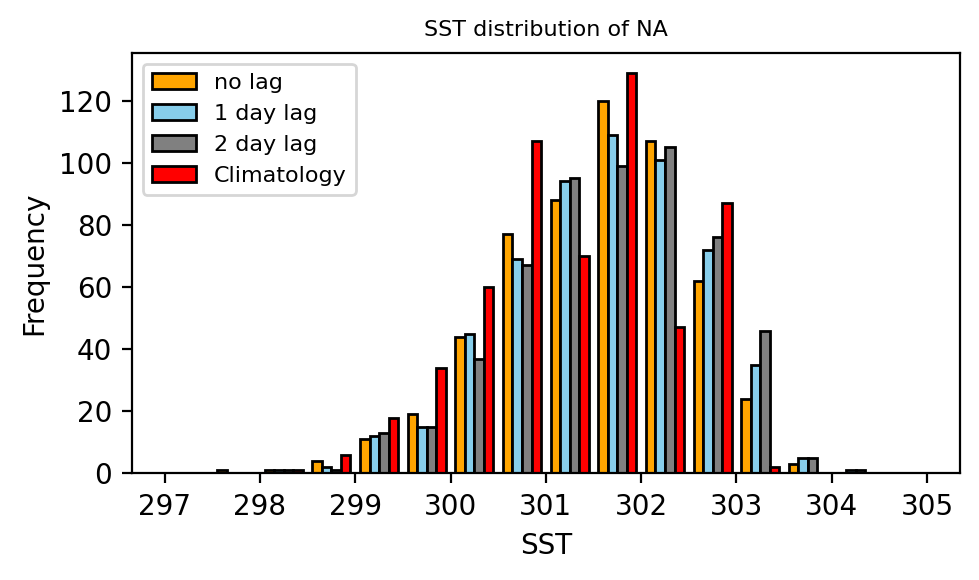

/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/PLOT/sst_diff_distribution_NA_3.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


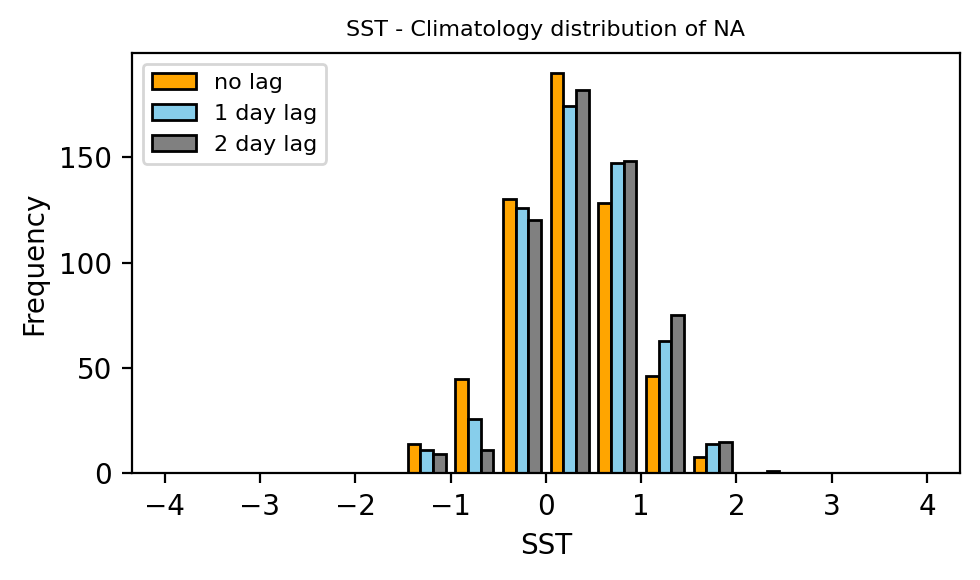

In [20]:
flnm_csv = [dir_o + 'global_RI_e5_lag0d_0.5radius_sst_NA.csv',
            dir_o + 'global_RI_e5_lag1d_0.5radius_sst_NA.csv',
            dir_o + 'global_RI_e5_lag2d_0.5radius_sst_NA.csv']

data_cli = sst_cli
bins = np.linspace(297, 305, 17)
hist_4(dir_plot, dir_o, 'SST', bins, flnm_csv, sst_cli)

bins = np.linspace(-4, 4, 17)
hist_3(dir_plot, dir_o, 'SST', bins, flnm_csv, sst_cli)

#### 2.1 Calculate Relative humidity at 600hPa

In [7]:
%%time
dir_pl = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/"
#dir_o = '/glade/derecho/scratch/mingge/ERA5/'
flnm_csv = dir_o + 'global_RI_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_rh_NA.csv"
print('output', flnm_csv)

if os.path.isfile(flnm_csv):
    print(flnm_csv, 'exist')
    df_rh = pd.read_csv(flnm_csv, delimiter=',', engine='python')
    rh_lmi = df_rh.rh
    print(df_rh)
else:
    rh_1d = np.zeros((ntim))
    
    for nt in range(ntim):
        dir = dir_pl + yyyys[nt] + mms[nt] + "/" 
        # units = "kg kg**-1" 
        flnm_q = dir + "e5.oper.an.pl.128_133_q.ll025sc." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"
        # units = "K" 
        flnm_t = dir + "e5.oper.an.pl.128_130_t.ll025sc." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"

        # Converting a string in a specific format to a datetime
        date_obj = datetime.strptime(yyyymmddhhs[nt], date_format)
        with xr.open_dataset(flnm_q) as ds:
            qq = ds.Q.sel(time = date_obj, level=600)

        with xr.open_dataset(flnm_t) as ds:
            tt = ds.T.sel(time = date_obj, level=600)
         
        pres = tt.copy()
        pres[:] = 600
        rh_tmp = relative_humidity_from_specific_humidity(pres.values*units.hPa, tt, qq)    

        rh_1d[nt] = rh_tmp.sel(latitude=slice(lat[nt]+rr, lat[nt]-rr), 
                    longitude=slice(lon[nt]-rr,lon[nt]+rr)).mean()
   
    ## write out
    data = { 'yyyymmddhh': yyyymmddhh, 'lat': lat, 'lon': lon, 'rh': rh_1d}

    # Create the pandas DataFrame
    df = pd.DataFrame(data)
    df.to_csv(flnm_csv, float_format="%.3f", index=False)    
 

output /glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/global_RI_e5_lag2d_0.5radius_rh_NA.csv
/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/global_RI_e5_lag2d_0.5radius_rh_NA.csv exist
     yyyymmddhh    lat     lon     rh
0    1980073018  10.75  319.25  0.647
1    1980073100  11.00  317.25  0.638
2    1980073118  12.25  311.00  0.710
3    1980080100  12.50  308.50  0.752
4    1980080106  12.50  306.50  0.729
..          ...    ...     ...    ...
562  2021092206  11.50  318.50  0.630
563  2021092212  11.50  317.00  0.658
564  2021092218  12.00  315.75  0.607
565  2021092300  12.25  314.50  0.590
566  2021092306  12.50  313.75  0.361

[567 rows x 4 columns]
CPU times: user 6.76 ms, sys: 0 ns, total: 6.76 ms
Wall time: 6.8 ms


#### 2.2 Calculate climatology of RH at 100 locations

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/PLOT/rh_distribution_NA_3.eps


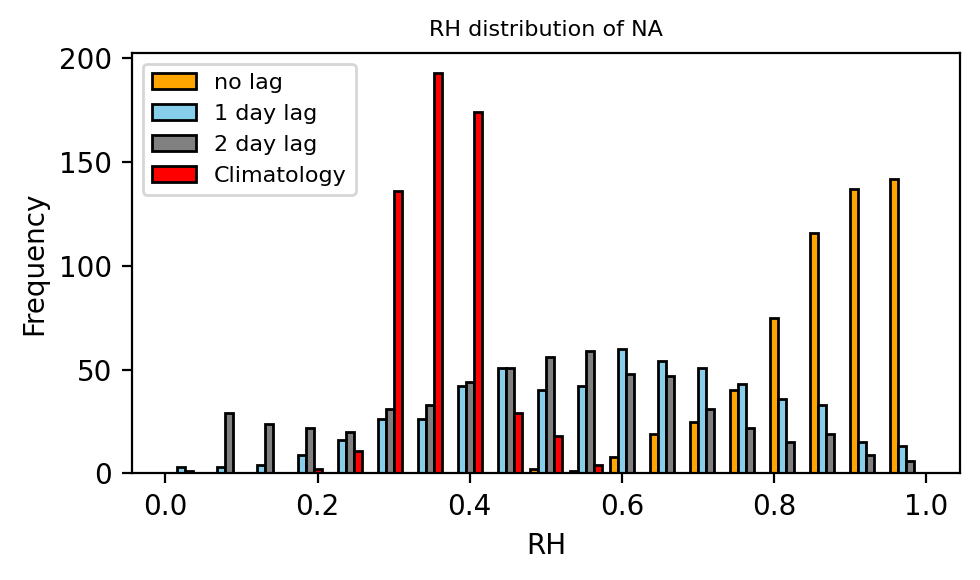

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/PLOT/rh_diff_distribution_NA_3.eps


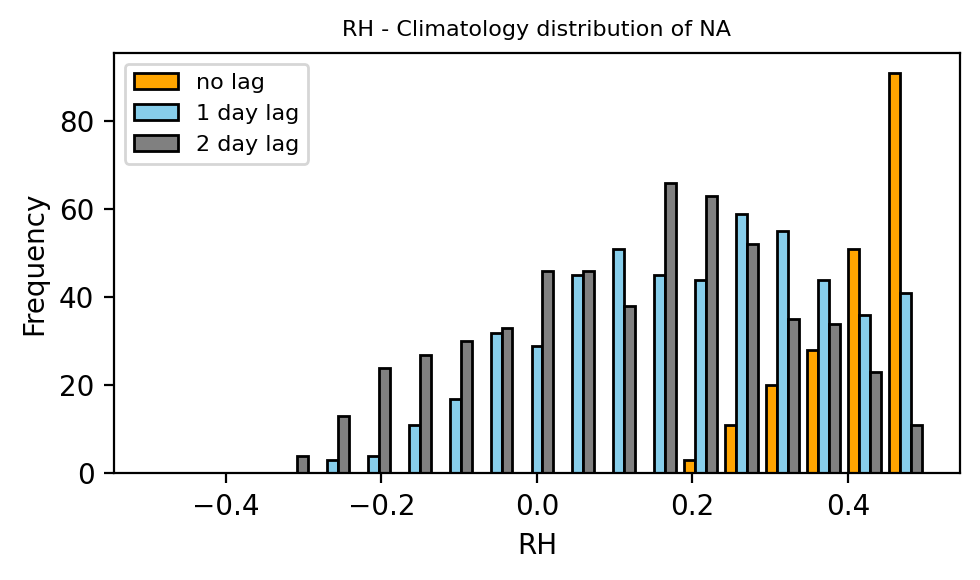

In [8]:
dir_cli = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/'
rh_cli = np.zeros((ntim))
year_ss = 1990
year_ee = 2020
for year in range(year_ss, year_ee + 1):
    flnm_nc = dir_cli + 'global_lmi_e5_' + str(rr) + 'radius_RH_NA_'+ str(year) +'_July-Sep.nc'
    with xr.open_dataset(flnm_nc) as ds:
        if year == year_ss:
            rh_cli_2d = ds.rh
        else:
            rh_cli_2d = rh_cli_2d + ds.rh
        
rh_cli_2d = rh_cli_2d/float(n_year)

for nt in range(ntim):
    rh_cli[nt] = rh_cli_2d.sel(lat=slice(lat[nt]+rr, lat[nt]-rr), 
                        lon=slice(lon[nt]-rr,lon[nt]+rr)).mean() 

flnm_csv = [dir_o + 'global_RI_e5_lag0d_0.5radius_rh_NA.csv',
            dir_o + 'global_RI_e5_lag1d_0.5radius_rh_NA.csv',
            dir_o + 'global_RI_e5_lag2d_0.5radius_rh_NA.csv']

data_cli = rh_cli
bins = np.linspace(0, 1, 20)
hist_4(dir_plot, dir_o, 'RH', bins, flnm_csv, rh_cli)

bins = np.linspace(-0.5, .5, 20)
hist_3(dir_plot, dir_o, 'RH', bins, flnm_csv, rh_cli)


#### 3.1 Relative vorticity at 850hPa

In [21]:
%%time
dir_pl = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/"
 
flnm_csv = dir_o + 'global_RI_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_vor_NA.csv"
print('output', flnm_csv)

if os.path.isfile(flnm_csv):
    print(flnm_csv, 'exist')
    df_vor = pd.read_csv(flnm_csv, delimiter=',', engine='python')
    vor_lmi = df_vor.vor
    print(df_vor.head())
else:
    vor_1d = np.zeros((ntim))
    
    for nt in range(ntim):
        dir = dir_pl + yyyys[nt] + mms[nt] + "/" 
        # units = "kg kg**-1" 
        flnm_vo = dir + "e5.oper.an.pl.128_138_vo.ll025sc." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"       
        #print(nt, ntim, flnm_vo)

        # Converting a string in a specific format to a datetime
        date_obj = datetime.strptime(yyyymmddhhs[nt], date_format)
        with xr.open_dataset(flnm_vo) as ds:
            vor_tmp = ds.VO.sel(time = date_obj, level=850)

        vor_1d[nt] = vor_tmp.sel(latitude=slice(lat[nt]+rr, lat[nt]-rr), 
                    longitude=slice(lon[nt]-rr,lon[nt]+rr)).mean()
   
    ## write out
    data = { 'yyyymmddhh': yyyymmddhh, 'lat': lat, 'lon': lon, 'vor': vor_1d}

    # Create the pandas DataFrame
    df = pd.DataFrame(data)
    df.to_csv(flnm_csv, float_format="%.6f", index=False)    


output /glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/global_RI_e5_lag0d_0.5radius_vor_NA.csv
CPU times: user 6min 10s, sys: 1min 2s, total: 7min 12s
Wall time: 9min 31s


#### 3.2 Calculate climatology of relative vorticity at 100 locations

In [22]:
vor_cli = np.zeros((ntim))
year_ss = 1990
year_ee = 2020 
for year in range(year_ss, year_ee + 1):
    flnm_nc = dir_cli + 'global_lmi_e5_' + str(rr) + 'radius_vor_NA_'+ str(year) +'_July-Sep.nc'
    with xr.open_dataset(flnm_nc) as ds:
        if year == year_ss:
            vor_cli_2d = ds.vorticity
        else:
            vor_cli_2d = vor_cli_2d + ds.vorticity
        
vor_cli_2d = vor_cli_2d/float(n_year)

for nt in range(ntim):
    vor_cli[nt] = vor_cli_2d.sel(lat=slice(lat[nt]+rr, lat[nt]-rr), 
                        lon=slice(lon[nt]-rr,lon[nt]+rr)).mean() 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/PLOT/vor_distribution_NA_3.eps


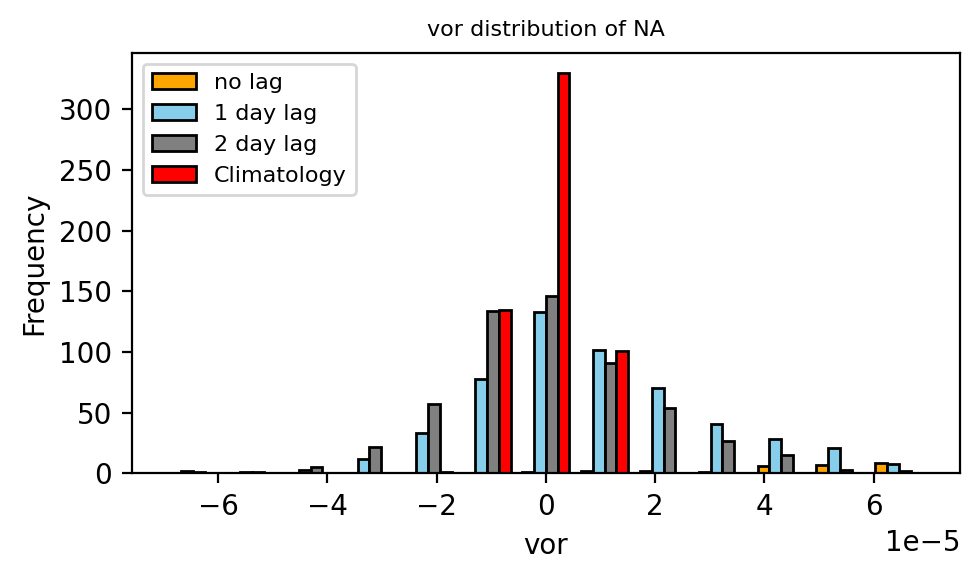

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/PLOT/vor_diff_distribution_NA_3.eps


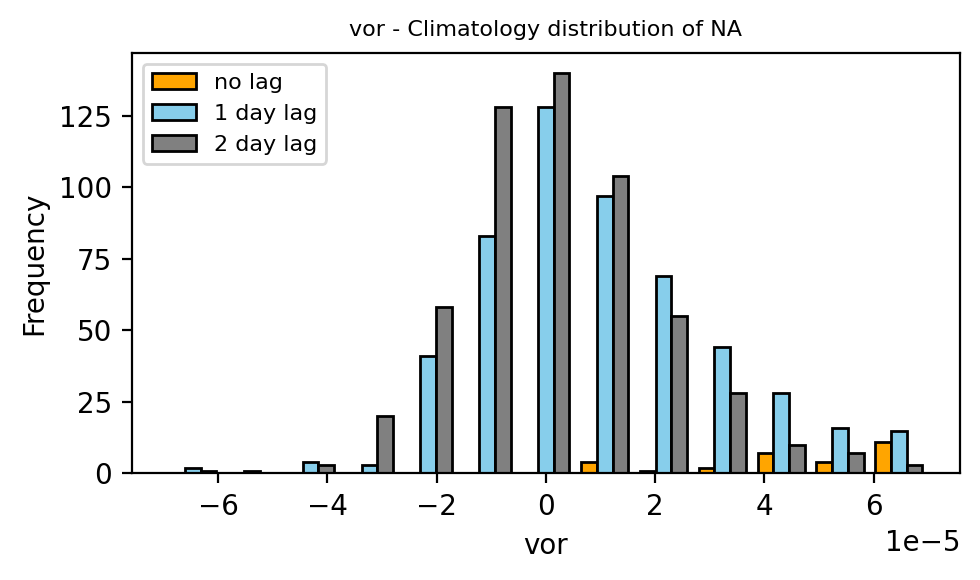

In [23]:
flnm_csv = [dir_o + 'global_RI_e5_lag0d_0.5radius_vor_NA.csv',
            dir_o + 'global_RI_e5_lag1d_0.5radius_vor_NA.csv',
            dir_o + 'global_RI_e5_lag2d_0.5radius_vor_NA.csv']

data_cli = rh_cli
bins = np.linspace(-0.00007, 0.00007, 14)
hist_4(dir_plot, dir_o, 'vor', bins, flnm_csv, vor_cli)
hist_3(dir_plot, dir_o, 'vor', bins, flnm_csv, vor_cli)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/vorticity850_distribution_NA.eps


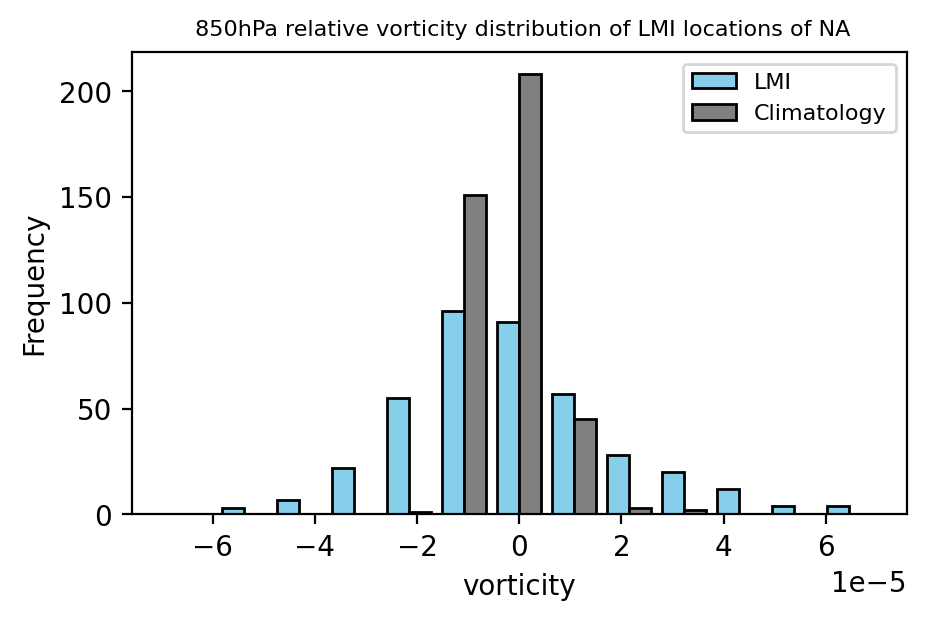

In [29]:

# Plotting a basic histogram
flnm_p = dir_plot + 'vorticity850_distribution_NA.eps'
print(flnm_p)
dpi = 200

fig = plt.figure(figsize=(5, 3), dpi = dpi)
bins = np.linspace(-0.00007, 0.00007, 14)
plt.hist([vor_lmi, vor_cli], bins, label=['LMI', 'Climatology'], color=['skyblue', 'grey'], edgecolor='black')
 
# Adding labels and title
plt.xlabel('vorticity')
plt.ylabel('Frequency')
plt.title(' 850hPa relative vorticity distribution of LMI locations of NA', fontsize=8)
plt.legend(loc='upper right', fontsize=8) 
plt.savefig(flnm_p, dpi=fig.dpi, bbox_inches='tight')
plt.show()        

/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/vorticity850dif_distribution_NA.eps


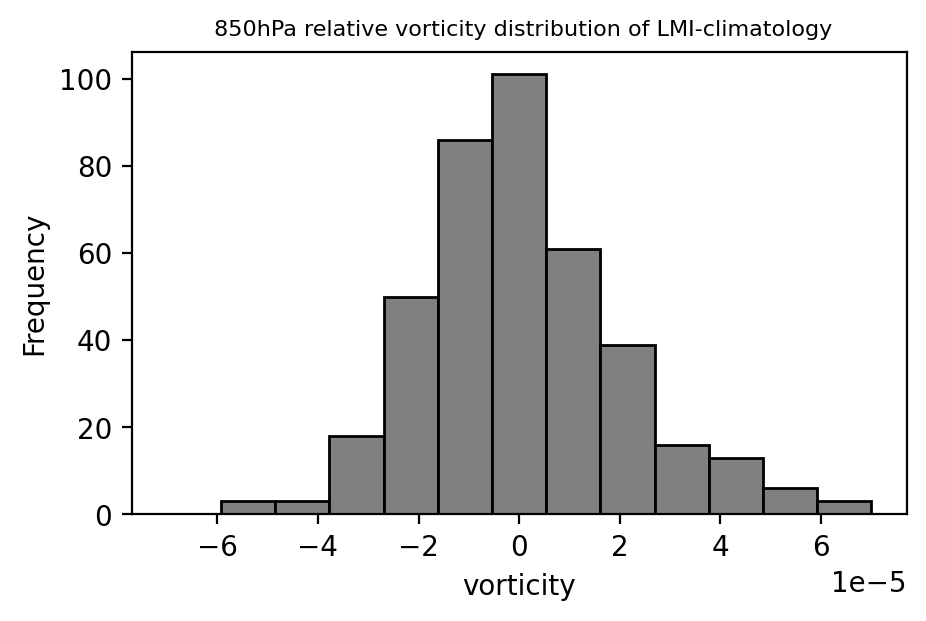

In [26]:
# Plotting a basic histogram
flnm_p = dir_plot + 'vorticity850dif_distribution_NA.eps'
print(flnm_p)
dpi = 200

fig = plt.figure(figsize=(5, 3), dpi = dpi)
bins = np.linspace(-0.00007, 0.00007, 14)
plt.hist([vor_lmi-vor_cli], bins, label=['LMI-Climatology'], color=['grey'], edgecolor='black')
 
# Adding labels and title
plt.xlabel('vorticity')
plt.ylabel('Frequency')
plt.title(' 850hPa relative vorticity distribution of LMI-climatology', fontsize=8)
#plt.legend(loc='upper right', fontsize=8) 
plt.savefig(flnm_p, dpi=fig.dpi, bbox_inches='tight')
plt.show()        